# Predikce vývoje časových řad
Tento notebook popisuje vývoj volby metody pro predikci vývoje časových řad.

## Načtení dat
Použijeme data z World Bank.

In [1]:
import pandas as pd
import world_bank_data as wb
import datetime

dataset_id = 'SP.DYN.TFRT.IN'
dataset_props = {
    'id': 'tfr',
    'name': 'Total fertility rate',
    'description': 'Počet dětí, které by žena mohla mít, kdyby po celý její život platily hodnoty plodnosti podle věku pro daný rok.',
    'unit': 'počet dětí'
}

regions = [
    'WLD', # World
    'EUU', # European Union
    'AUT',
    'BEL',
    'BGR',
    'HRV',
    'CYP',
    'CZE',
    'DNK',
    'EST',
    'FIN',
    'FRA',
    'DEU',
    'GRC',
    'HUN',
    'IRL',
    'ITA',
    'LVA',
    'LTU',
    'LUX',
    'MLT',
    'NLD',
    'POL',
    'PRT',
    'ROU',
    'SVK',
    'SVN',
    'ESP',
    'SWE',
    'NOR', # Others
    'GBR'
]

# Collect data since 1980 until now
year = datetime.date.today().strftime("%Y")
series = wb.get_series(dataset_id, date='1980:%s' % year, id_or_value='id', simplify_index=True)

tfr = {}

for region in regions:
    data = series[region]

    # Strip NaNs
    index = data.index
    start = 0
    while start <= len(index) - 1:
        if not pd.isnull(data[index[start]]):
            break
        start = start + 1
    end = len(index) - 1
    while end >= 0:
        if not pd.isnull(data[index[end]]):
            break
        end = end - 1
    data = data.iloc[start:(end + 1)] # Last index is exclusive

    # Compute intermediary missing values using interpolation
    data = data.interpolate()

    if data.size < 3:
        print('Skipping %s for %s' % (dataset_id, region))
    else:
        tfr[region] = {
            'data': data
        }

## Stacionarita
Pomocí ADF oveříme stacionaritu jednotlivých časových řad.

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_is_stationary(data):
    result = adfuller(data, autolag='AIC')
    return True if result[1] < 0.05 else False

for region in tfr:
    tfr[region]['stationary'] = adf_is_stationary(tfr[region]['data'])
    print(region + ': ' + ('stationary' if tfr[region]['stationary'] else 'non-stationary'))

WLD: stationary
EUU: stationary
AUT: stationary
BEL: non-stationary
BGR: stationary
HRV: non-stationary
CYP: non-stationary
CZE: non-stationary
DNK: stationary
EST: stationary
FIN: non-stationary
FRA: non-stationary
DEU: non-stationary
GRC: stationary
HUN: non-stationary
IRL: non-stationary
ITA: stationary
LVA: non-stationary
LTU: non-stationary
LUX: non-stationary
MLT: non-stationary
NLD: non-stationary
POL: non-stationary
PRT: stationary
ROU: non-stationary
SVK: non-stationary
SVN: non-stationary
ESP: stationary
SWE: non-stationary
NOR: non-stationary
GBR: non-stationary


## Selekce modelu pro stacionární časové řady
Vyzkoušíme najít nejlepší model pro stacionární časové řady vývoje TFR.
Máme k dispozici 41 hodnot, které rozdělíme zhruba v poměru 3:1 na trénovací a testovací dataset.
Předpovídat tak budeme na 10 let dopředu pomocí předchozích 31 hodnot.
Jako hodnotící kritérium použijeme MSE.

### AR model
Chybu daných hyperparametrů získáme jako součet chyb pro jednotlivé predikce.
Data normalizujeme, aby získané chyby byly porovnatelné.

In [3]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def ar(data, train_count, lags, trend, plot = False):
    train, test = data[:train_count],data[train_count:]

    # Unset frequency, as the data is most probably not periodic
    train.index = pd.DatetimeIndex(train.index.values)

    model = AutoReg(train, lags=lags, trend=trend, seasonal=False, period=None)
    model_fit = model.fit()

    pred = model_fit.predict(len(train), len(test) + len(train) - 1, dynamic=False)

    # Optional output
    if plot:
        fig = plt.figure()
        fig.set_figwidth(12)
        fig.set_figheight(5)
        plt.title('Prediction')
        plt.plot(data, color='teal')
        plt.plot(test.index, pred.values, color='red')
        plt.show()
    
    return mean_squared_error(test, pred)

# Construct a parameter grid and try fitting the models for each stationary TFR series.
param_grid = ParameterGrid({
    'lags': [2, 3, 4, 5, 6, 8, 10],
    'trend': ['n', 'c', 't', 'ct']
})
errors = []

for params in param_grid:
    error_sum = 0
    for data in tfr.values():
        if data['stationary']:
            # Normalize data to obtain comparable errors.
            error_sum += ar(
                data=(data['data'] - data['data'].mean()) / (data['data'].max() - data['data'].min()),
                train_count=31,
                lags=params['lags'],
                trend=params['trend'])
    errors.append(error_sum)

# Get the parameters with the lowest cumulative error across regions.
min_error_ar = 1000000
best_params_ar = None
for i in range(0, len(errors) - 1):
    if errors[i] < min_error_ar:
        min_error_ar = errors[i]
        best_params_ar = param_grid[i]

print(best_params_ar)

print(errors)

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment su

{'trend': 'n', 'lags': 3}
[0.15214566016025274, 0.20646281439637731, 0.3335602276023391, 1.2565589026182755, 0.11011878039341128, 0.12648758305678834, 0.23086935868596523, 1.1674726934856916, 0.12474659807231822, 0.12559229697444171, 0.22853644962477707, 1.248221986578293, 0.16180253024968622, 0.16594672067138902, 0.2751493851639317, 1.3903183432505302, 0.15668209169724714, 0.18364811366840736, 0.31708161061643847, 1.5871467970979478, 0.1934746973906252, 0.366892714189084, 0.6250760937272527, 2.1054328001093268, 0.277265775541022, 0.32964945518284006, 0.4412635705446107, 1.5269187078720285]


/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/t

Zobrazíme některé výsledky používající zjištěné nejlepší hyperparametry.

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


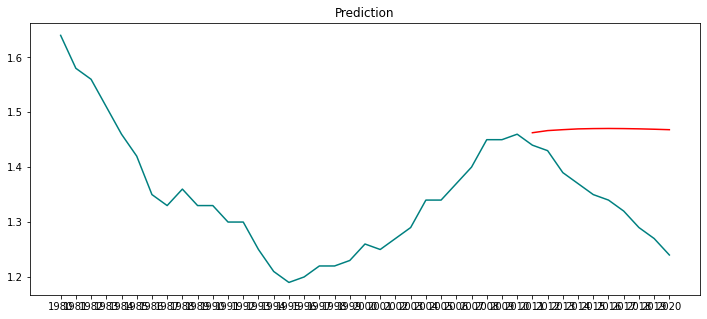

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


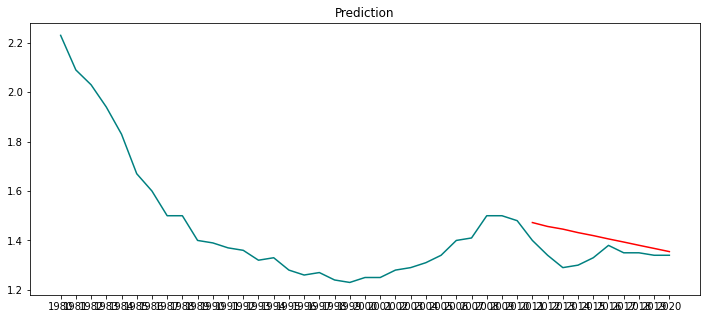

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


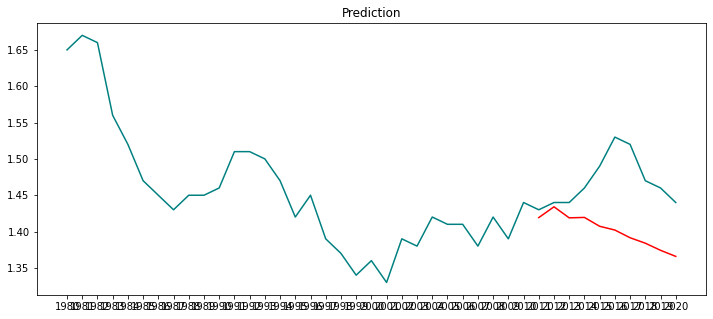

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


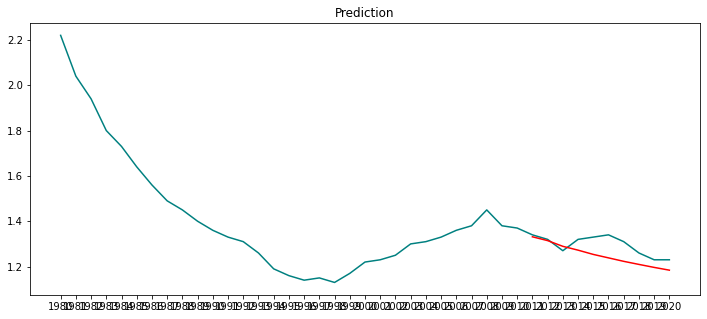

0.003221644348400704

In [4]:
ar(tfr['ITA']['data'], 31, best_params_ar['lags'], best_params_ar['trend'], plot=True)
ar(tfr['GRC']['data'], 31, best_params_ar['lags'], best_params_ar['trend'], plot=True)
ar(tfr['AUT']['data'], 31, best_params_ar['lags'], best_params_ar['trend'], plot=True)
ar(tfr['ESP']['data'], 31, best_params_ar['lags'], best_params_ar['trend'], plot=True)

#### Autokorelace
Autoregresní model je citlivý na počet lagů, které použijeme.
Ověříme proto jejich nalezený optimální počet pomocí grafu autokorelací podle lagu.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

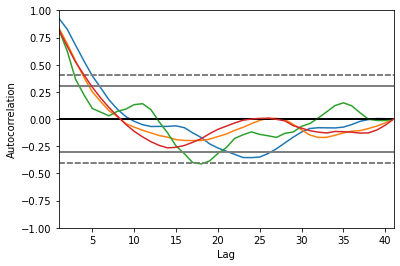

In [5]:
pd.plotting.autocorrelation_plot(tfr['DNK']['data'])
pd.plotting.autocorrelation_plot(tfr['GRC']['data'])
pd.plotting.autocorrelation_plot(tfr['AUT']['data'])
pd.plotting.autocorrelation_plot(tfr['ESP']['data'])

Autokorelace se pro vybrané řady skutečně stává nevýznamnou kolem 4. lagu.
Zdá se tedy, že nalezené hyperparametry AR modelu jsou smysluplné.

### ARMA
Rozšíříme AR model o moving average složku.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

def arma(data, train_count, ar, ma, trend, plot = False):
    train, test = data[:train_count],data[train_count:]

    # Unset frequency, as the data is most probably not periodic
    train.index = pd.DatetimeIndex(train.index.values)

    model = ARIMA(train, order=(ar, 0, ma), trend=trend)
    model_fit = model.fit()
    pred = model_fit.predict(len(train), len(test) + len(train) - 1, dynamic=False)

    # Optional output
    if plot:
        fig = plt.figure()
        fig.set_figwidth(12)
        fig.set_figheight(5)
        plt.title('Prediction')
        plt.plot(data, color='teal')
        plt.plot(test.index, pred.values, color='red')
        plt.show()
    
    return mean_squared_error(test, pred)

# Construct a parameter grid and try fitting the models for each stationary TFR series.
param_grid = ParameterGrid({
    'ar': [2, 3, 4, 5, 6, 8, 10],
    'ma': [0, 1, 2, 3, 4, 5, 6],
    'trend': ['n', 'c', 't', 'ct']
})
errors = []

for params in param_grid:
    error_sum = 0
    for data in tfr.values():
        if data['stationary']:
            # Normalize data to obtain comparable errors.
            error_sum += arma(
                data=(data['data'] - data['data'].mean()) / (data['data'].max() - data['data'].min()),
                train_count=31,
                ar=params['ar'],
                ma=params['ma'],
                trend=params['trend'])
    errors.append(error_sum)

# Get the parameters with the lowest cumulative error across regions.
min_error_arma = 10000000
best_params_arma = None
for i in range(0, len(errors) - 1):
    if errors[i] < min_error_arma:
        min_error_arma = errors[i]
        best_params_arma = param_grid[i]

print(best_params_arma)

print(errors)

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provi

{'trend': 'n', 'ma': 0, 'ar': 3}
[0.18646859041094108, 0.2800232188136334, 0.30595888900143103, 0.23987999953573988, 0.2729324648472774, 0.2330404338566045, 0.21759712485881033, 0.11939268643076224, 0.29692254119522893, 0.25097977944851163, 0.21541030068085615, 0.28182287666482386, 0.17817994611619722, 0.22426362477606498, 0.1507171157360131, 0.16886944822592476, 0.1540408307513702, 0.20017300165510818, 0.22118618052674707, 0.18126334604431657, 0.24299496636002335, 0.19131798505394376, 0.16274322879828237, 0.2587680867131892, 0.1521773038384992, 0.27449712992779957, 0.28062621509377855, 0.2750856337471281, 0.19502153058600036, 0.1856894872323466, 0.2193755818482427, 0.17126739912501002, 0.18635092644659104, 0.35188014469383433, 0.30230500100398855, 0.24376284406797047, 0.18728494760051775, 0.19354721749228665, 0.18363509820019636, 0.13616646550071926, 0.17352359983325044, 0.1869517951450602, 0.2525119724100517, 0.27819179418505957, 0.2569961402410536, 0.29793870961438834, 0.28000086586

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Zobrazíme některé výsledky používající zjištěné nejlepší hyperparametry.

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


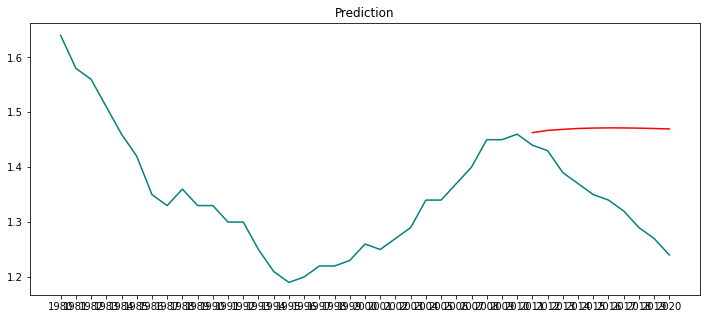

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


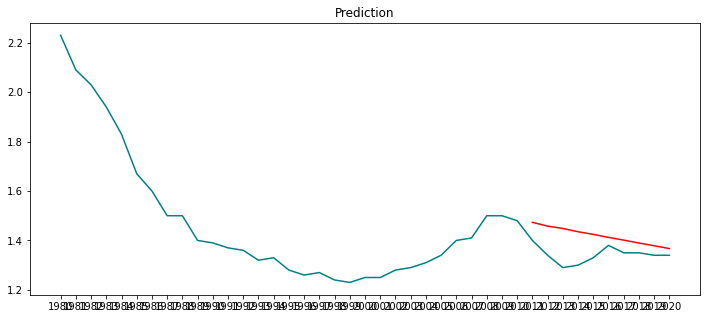

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


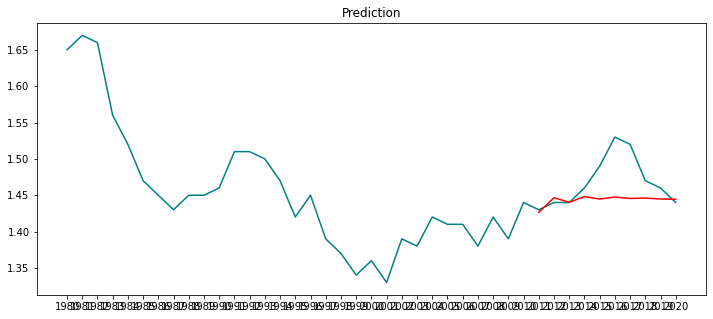

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


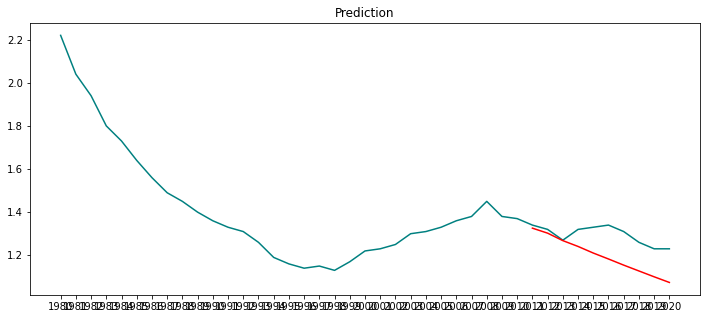

0.012893422894305121

In [12]:
arma(tfr['ITA']['data'], 31, best_params_arma['ar'], best_params_arma['ma'], best_params_arma['trend'], plot=True)
arma(tfr['GRC']['data'], 31, best_params_arma['ar'], best_params_arma['ma'], best_params_arma['trend'], plot=True)
arma(tfr['AUT']['data'], 31, best_params_arma['ar'], best_params_arma['ma'], best_params_arma['trend'], plot=True)
arma(tfr['ESP']['data'], 31, best_params_arma['ar'], best_params_arma['ma'], best_params_arma['trend'], plot=True)

### Výsledek
V případě hledání hyperparametrů ARMA ve tvaru (p, q) se ukázala jako nejlepší kombinace (3, 0).
Tato konfigurace odpovídá AR modelu se 3 lagy, který již byl výše vybrán jako nejlepší AR model.

## Model pro nestacionární časové řady
Najdeme hyperparametry pro ARIMA model.
Optimální diferenciaci nalezneme pomocí ADF - test, který byl použitý také pro rozhodnutí o stacionaritě.
Pro porovnávání modelů mezi sebou se použije AIC kritérium, které balancuje mezi jednoduchostí modelu (proti overfitting) a kvalitou předpovědi.

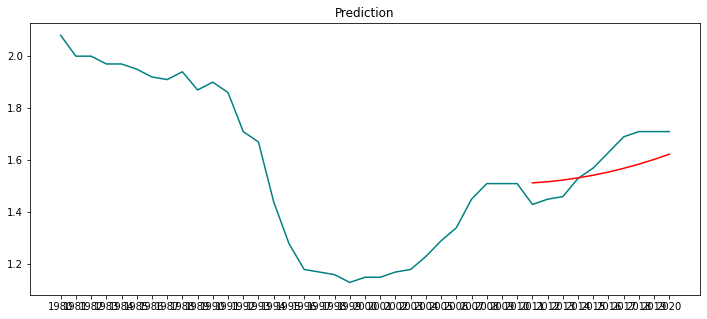

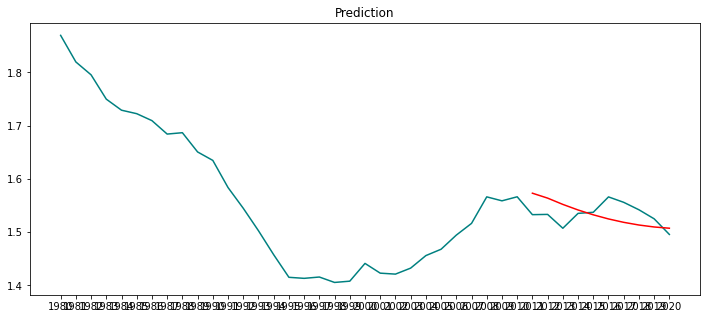

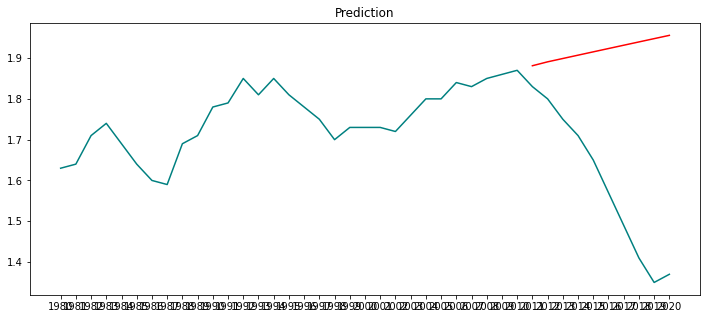

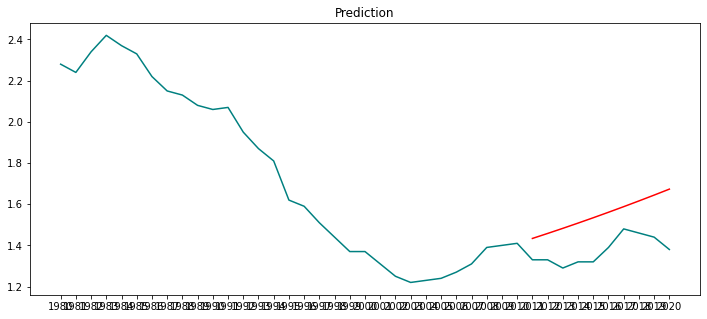

-76.54205257931761

In [8]:
import pmdarima as pm

def arima(data, train_count=31, d=None, diff='adf', plot=False):
    train, test = data[:train_count],data[train_count:]

    model_fit = pm.auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10,
        seasonal=False, m=1, # No seasonality
        d=d, max_d=2, test=diff, # Differencing
        trace=False, error_action='ignore', suppress_warnings=True, # Logging
        stepwise=False)
    # model_fit.summary()
    
    pred = model_fit.predict(len(test))

    if plot:
        fig = plt.figure()
        fig.set_figwidth(12)
        fig.set_figheight(5)
        plt.title('Prediction')
        plt.plot(data, color='teal')
        plt.plot(test.index, pred, color='red')
        plt.show()
    
    return model_fit.aic()

arima(tfr['CZE']['data'], plot=True)
arima(tfr['EUU']['data'], plot=True)
arima(tfr['FIN']['data'], plot=True)
arima(tfr['POL']['data'], plot=True)

### Porovnání ARIMA s AR modelem v případě stacionární řady podle ADF

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


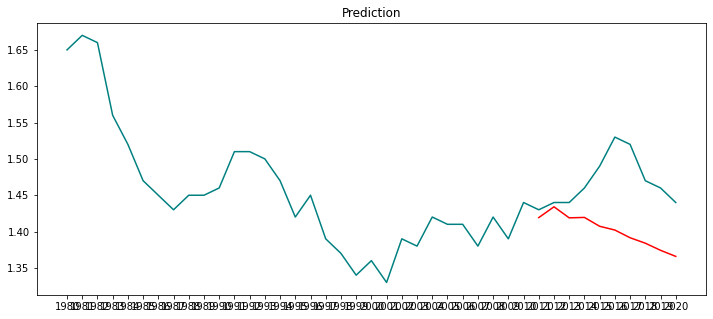

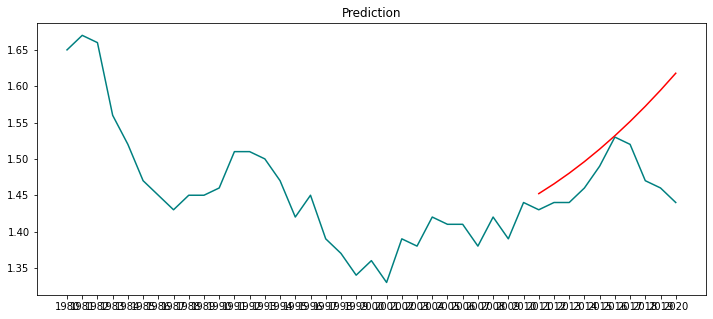

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


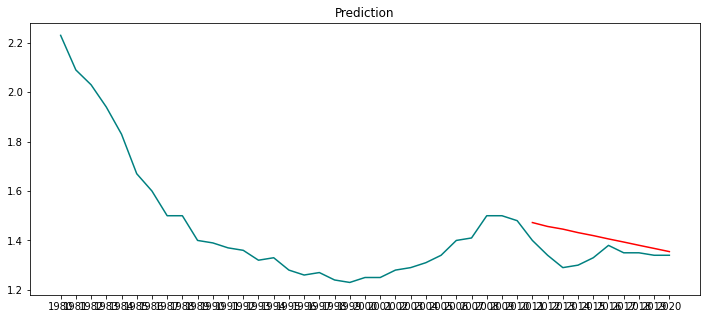

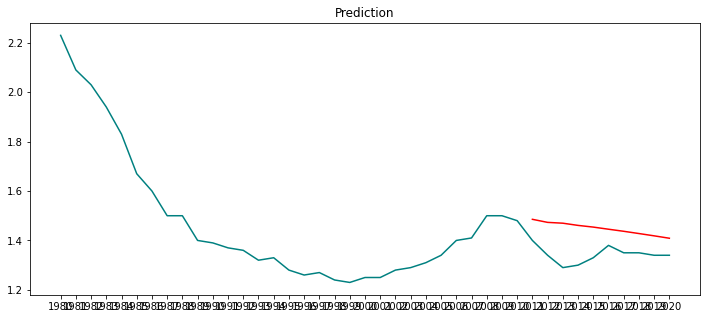

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


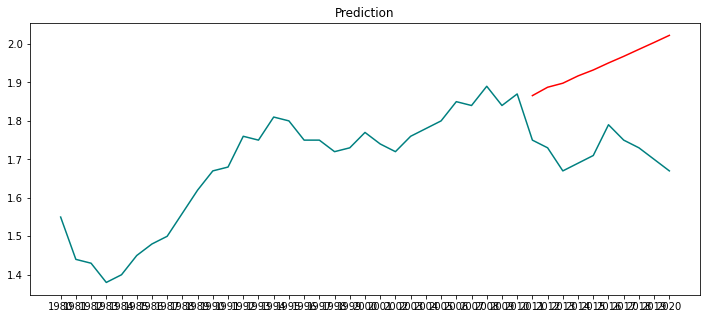

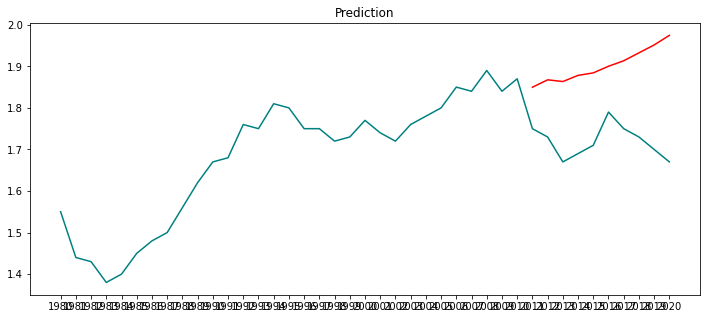

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


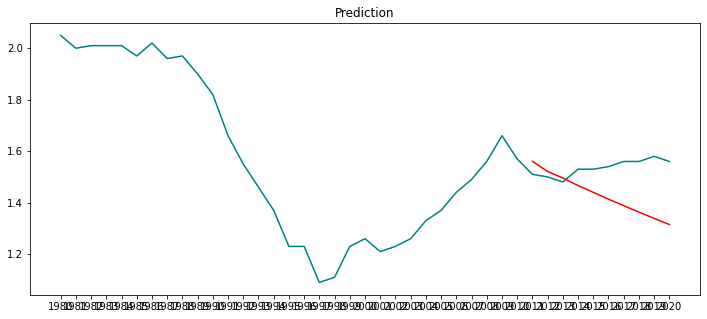

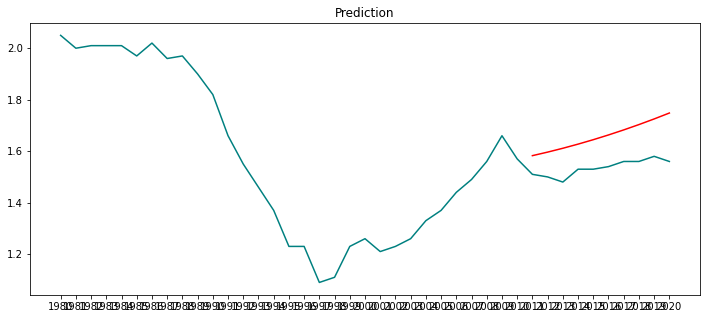

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


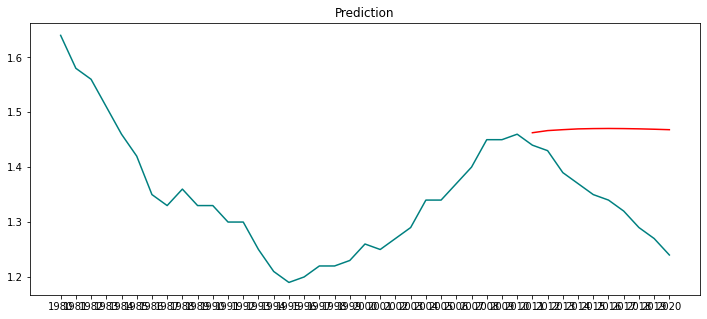

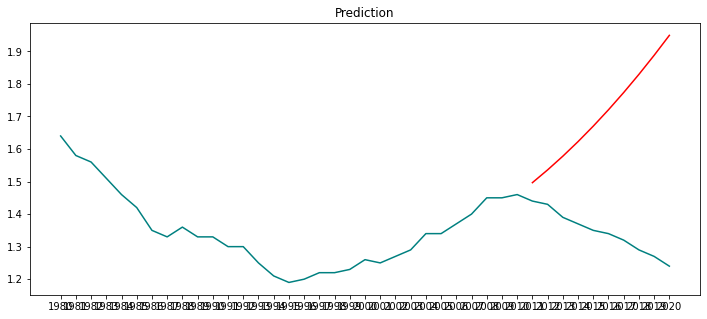

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


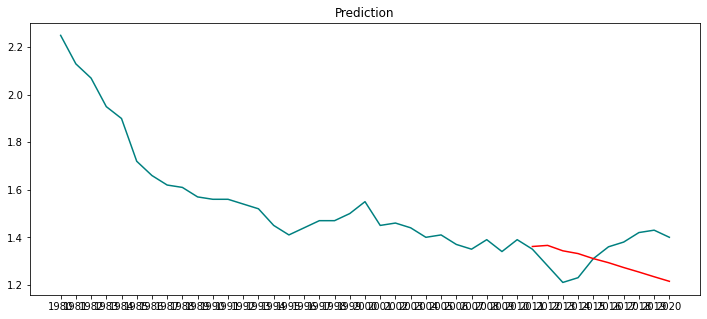

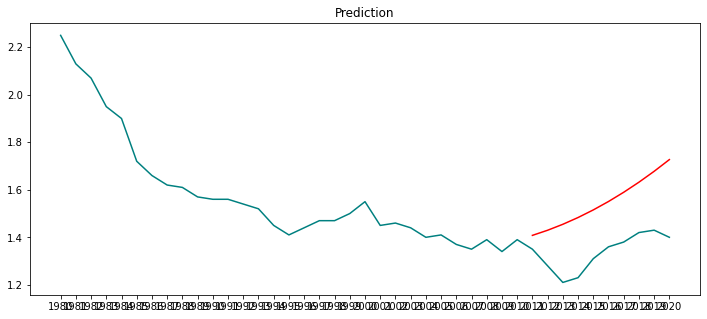

-88.45279520666578

In [9]:
ar(tfr['AUT']['data'], 31, 3, 'n', plot=True)
arima(tfr['AUT']['data'], plot=True)
ar(tfr['GRC']['data'], 31, 3, 'n', plot=True)
arima(tfr['GRC']['data'], plot=True)
ar(tfr['DNK']['data'], 31, 3, 'n', plot=True)
arima(tfr['DNK']['data'], plot=True)
ar(tfr['BGR']['data'], 31, 3, 'n', plot=True)
arima(tfr['BGR']['data'], plot=True)
ar(tfr['ITA']['data'], 31, 3, 'n', plot=True)
arima(tfr['ITA']['data'], plot=True)
ar(tfr['PRT']['data'], 31, 3, 'n', plot=True)
arima(tfr['PRT']['data'], plot=True)

## Selekce kritéria stacionarity 
AIC kritérium přechází overfittingu tím, že započítává nejen kvalitu předpovědi, ale i jednoduchost modelu.
Pro predikci všech časových řad proto použijeme hledání vhodného ARIMA modelu s hodnocením modelů pomocí AIC.
Vyhneme se tak i problému stacionarity celé časové řady vs. výřezu vzniklého při dělení dat.

Inferenci vhodného počtu diferenciací lze ale provádět i podle jiných testů než ADF.
Podle nejlepšího průměrného AIC pro všechny časové řady proto vybereme vhodné kritérium stacionarity.
Volit budeme mezi ADF a KPSS.

Je třeba ale mít na paměti, že vzhledem k malému rozsahu dat a pravděpodobné závislosti TFR na mnoha jiných ukazatelích nebude pouhý autoregresní model nikdy výjimečně dobrý.

In [10]:
errors_adf = 0
errors_kpss = 0

for data in tfr.values():
    errors_adf += arima(
        data=data['data'],
        diff='adf')
    errors_kpss += arima(
        data=data['data'],
        diff='kpss')

# Get the parameters with the lowest cumulative error across regions.
print(errors_adf)
print(errors_kpss)

-3094.8787691904463
-3232.324593588849


KPSS poskytuje lepší výsledky, bude proto použitý ve finální implementaci.

Níže je k dispozici náhled několika predikcí.

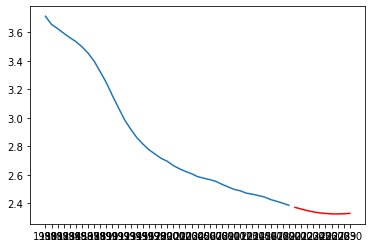

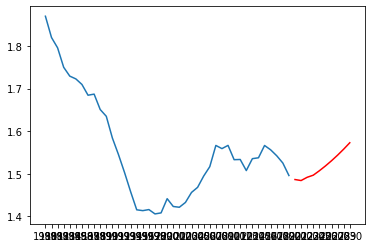

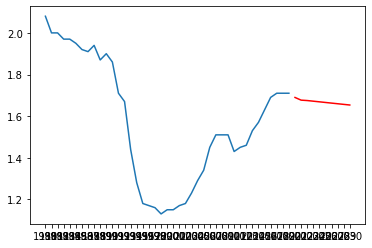

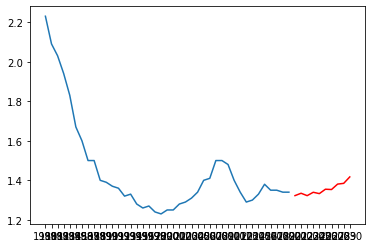

In [11]:
def predict(data, pred_len):
    model_fit = pm.auto_arima(data, start_p=0, start_q=0, max_p=10, max_q=10,
        seasonal=False, m=1, # No seasonality
        d=None, max_d=2, test='kpss', # Differencing
        trace=False, error_action='ignore', suppress_warnings=True, # Logging
        stepwise=False)
        
    pred = model_fit.predict(pred_len)

    last_year = int(data.index[-1]) + 1
    series = pd.Series(pred, index=[str(i) for i in range(last_year, last_year + pred_len)])

    plt.plot(data)
    plt.plot(series, c='r')
    plt.show()

predict(tfr['WLD']['data'], 10)
predict(tfr['EUU']['data'], 10)
predict(tfr['CZE']['data'], 10)
predict(tfr['GRC']['data'], 10)